In [102]:
# Imports

import numpy as np
from collections import deque

%run traffic_simulation.ipynb

In [129]:
# Change Detection

class DW_ValueChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between two subsequent windows.
    """
    def __init__(self, window_size, threshold):
        self.window_size = window_size
        self.threshold = threshold
        self.y_history = deque(maxlen=window_size)
        self.avg_history = deque(maxlen=window_size)
        self.var_history = deque(maxlen=window_size)
        
    def update(self, sample):
        baseline_avg, baseline_var, pilot_avg, pilot_var = self.__update_stats(sample)
        signal = self.__signal(baseline_avg, baseline_var, pilot_avg, pilot_var)
        return signal
    
    def __signal(self, baseline_avg, baseline_var, pilot_avg, pilot_var):
        if abs(pilot_avg - baseline_avg) > self.threshold*np.sqrt((baseline_var + pilot_var)/self.window_size):
            return 1
        else:
            return 0
    
    def __update_stats(self, y):
        current_length = len(self.y_history)
        if current_length < self.window_size:
            self.y_history.append(y)
            self.avg_history.append(np.mean(self.y_history))
            self.var_history.append(np.var(self.y_history))
            removed_avg, removed_var = self.avg_history[-1], self.var_history[-1]
        else:
            removed_y = self.y_history.popleft()
            self.y_history.append(y)
            removed_avg = self.avg_history.popleft()
            self.avg_history.append(self.avg_history[-1] + (y - removed_y)/current_length)
            removed_var = self.var_history.popleft()
            self.var_history.append(self.var_history[-1]
                                    + ((y - self.avg_history[-1])**2 - (removed_y - removed_avg)**2)
                                    /(current_length - 1))
        return removed_avg, removed_var, self.avg_history[-1], self.var_history[-1]
    
    
class DW_FrequencyChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between two subsequent windows.
    """
    def __init__(self, window_size, threshold):
        self.window_size = window_size
        self.threshold = threshold
        self.y_history = deque(maxlen=window_size)
        self.avg_history = deque(maxlen=window_size)
        self.var_history = deque(maxlen=window_size)
        self.prev = 0
        
    def update(self, time):
        sample = time - self.prev
        self.prev = time
        baseline_avg, baseline_var, pilot_avg, pilot_var = self.__update_stats(sample)
        signal = self.__signal(baseline_avg, baseline_var, pilot_avg, pilot_var)
        return signal
    
    def __signal(self, baseline_avg, baseline_var, pilot_avg, pilot_var):
        if abs(pilot_avg - baseline_avg) > self.threshold*np.sqrt((baseline_var + pilot_var)/self.window_size):
            return 1
        else:
            return 0
    
    def __update_stats(self, y):
        current_length = len(self.y_history)
        if current_length < self.window_size:
            self.y_history.append(y)
            self.avg_history.append(np.mean(self.y_history))
            self.var_history.append(np.var(self.y_history))
            removed_avg, removed_var = self.avg_history[-1], self.var_history[-1]
        else:
            removed_y = self.y_history.popleft()
            self.y_history.append(y)
            removed_avg = self.avg_history.popleft()
            self.avg_history.append(self.avg_history[-1] + (y - removed_y)/current_length)
            removed_var = self.var_history.popleft()
            self.var_history.append(self.var_history[-1]
                                    + ((y - self.avg_history[-1])**2 - (removed_y - removed_avg)**2)
                                    /(current_length - 1))
        return removed_avg, removed_var, self.avg_history[-1], self.var_history[-1]
    
    
class DW_ChangeDetector:
    """
    Detect changes in real time data streams. Measures difference between the subsequent windows.
    """
    def __init__(self, val_window, val_thres, freq_window, freq_thres):
        self.val_cd = DW_ValueChangeDetector(val_window, val_thres)
        self.freq_cd = DW_FrequencyChangeDetector(freq_window, freq_thres)
        
    def update(self, record):
        val_signal = 2*self.val_cd.update(record[1])
        freq_signal = self.freq_cd.update(record[0])
        return val_signal, freq_signal

In [194]:
# Grid search training

# Value change detection and frequency change detection are independent, so we can use grid search
# independently for each to reduce the search space.

stream_len = 100000
ep_len = 1000
n_win_sz = 10
n_thres = 10

def evaluate_change_detector(window_size, threshold, stream, true_signal, change_type):
    if change_type == 'value':
        cd = DW_ValueChangeDetector(window_size, threshold)
        stream = stream[:, 1].copy()
        true_signal = true_signal.copy()
        true_signal[true_signal==1] = 0
        true_signal = true_signal/2
    elif change_type == 'frequency':
        cd = DW_FrequencyChangeDetector(window_size, threshold)
        stream = stream[:, 0].copy()
        true_signal = true_signal.copy()
        true_signal[true_signal==2] = 0
    else:
        raise("Muppet")
        
    pred_signal = np.empty(stream.shape)
    for i, sample in enumerate(stream):
        pred_signal[i] = cd.update(sample)
    pred_signal = np.concatenate((pred_signal[window_size:], np.zeros(window_size)))
    pred_signal[:window_size] = np.zeros(window_size)
    
    return np.mean(pred_signal == true_signal)

win_szs = np.floor(np.linspace(ep_len/n_win_sz, ep_len, n_win_sz)).astype(int)
thress = np.linspace(1, 10, n_thres)

stream, true_signal = generate_stream(length=stream_len, episode_length=ep_len, intensity=0.5,
                                      abs_alpha_min=0.3, abs_alpha_max=0.9, 
                                      abs_delta_mean=3, delta_var = 1, seed=3)

val_accuracy = np.zeros((n_win_sz, n_thres))
for i, win_sz in enumerate(win_szs):
    for j, thres in enumerate(thress):
        val_accuracy[i, j] = evaluate_change_detector(win_sz.item(), thres, stream, true_signal, 'value')
        
print("Value accuracy: ", val_accuracy.max())
        
freq_accuracy = np.zeros((n_win_sz, n_thres))
for i, win_sz in enumerate(win_szs):
    for j, thres in enumerate(thress):
        freq_accuracy[i, j] = evaluate_change_detector(win_sz.item(), thres, stream, true_signal, 'frequency')

print("Frequency accuracy: ", freq_accuracy.max())

Value accuracy:  0.947473305374617
Frequency accuracy:  0.8972071027036673


Accuracy:  0.8660757661382271


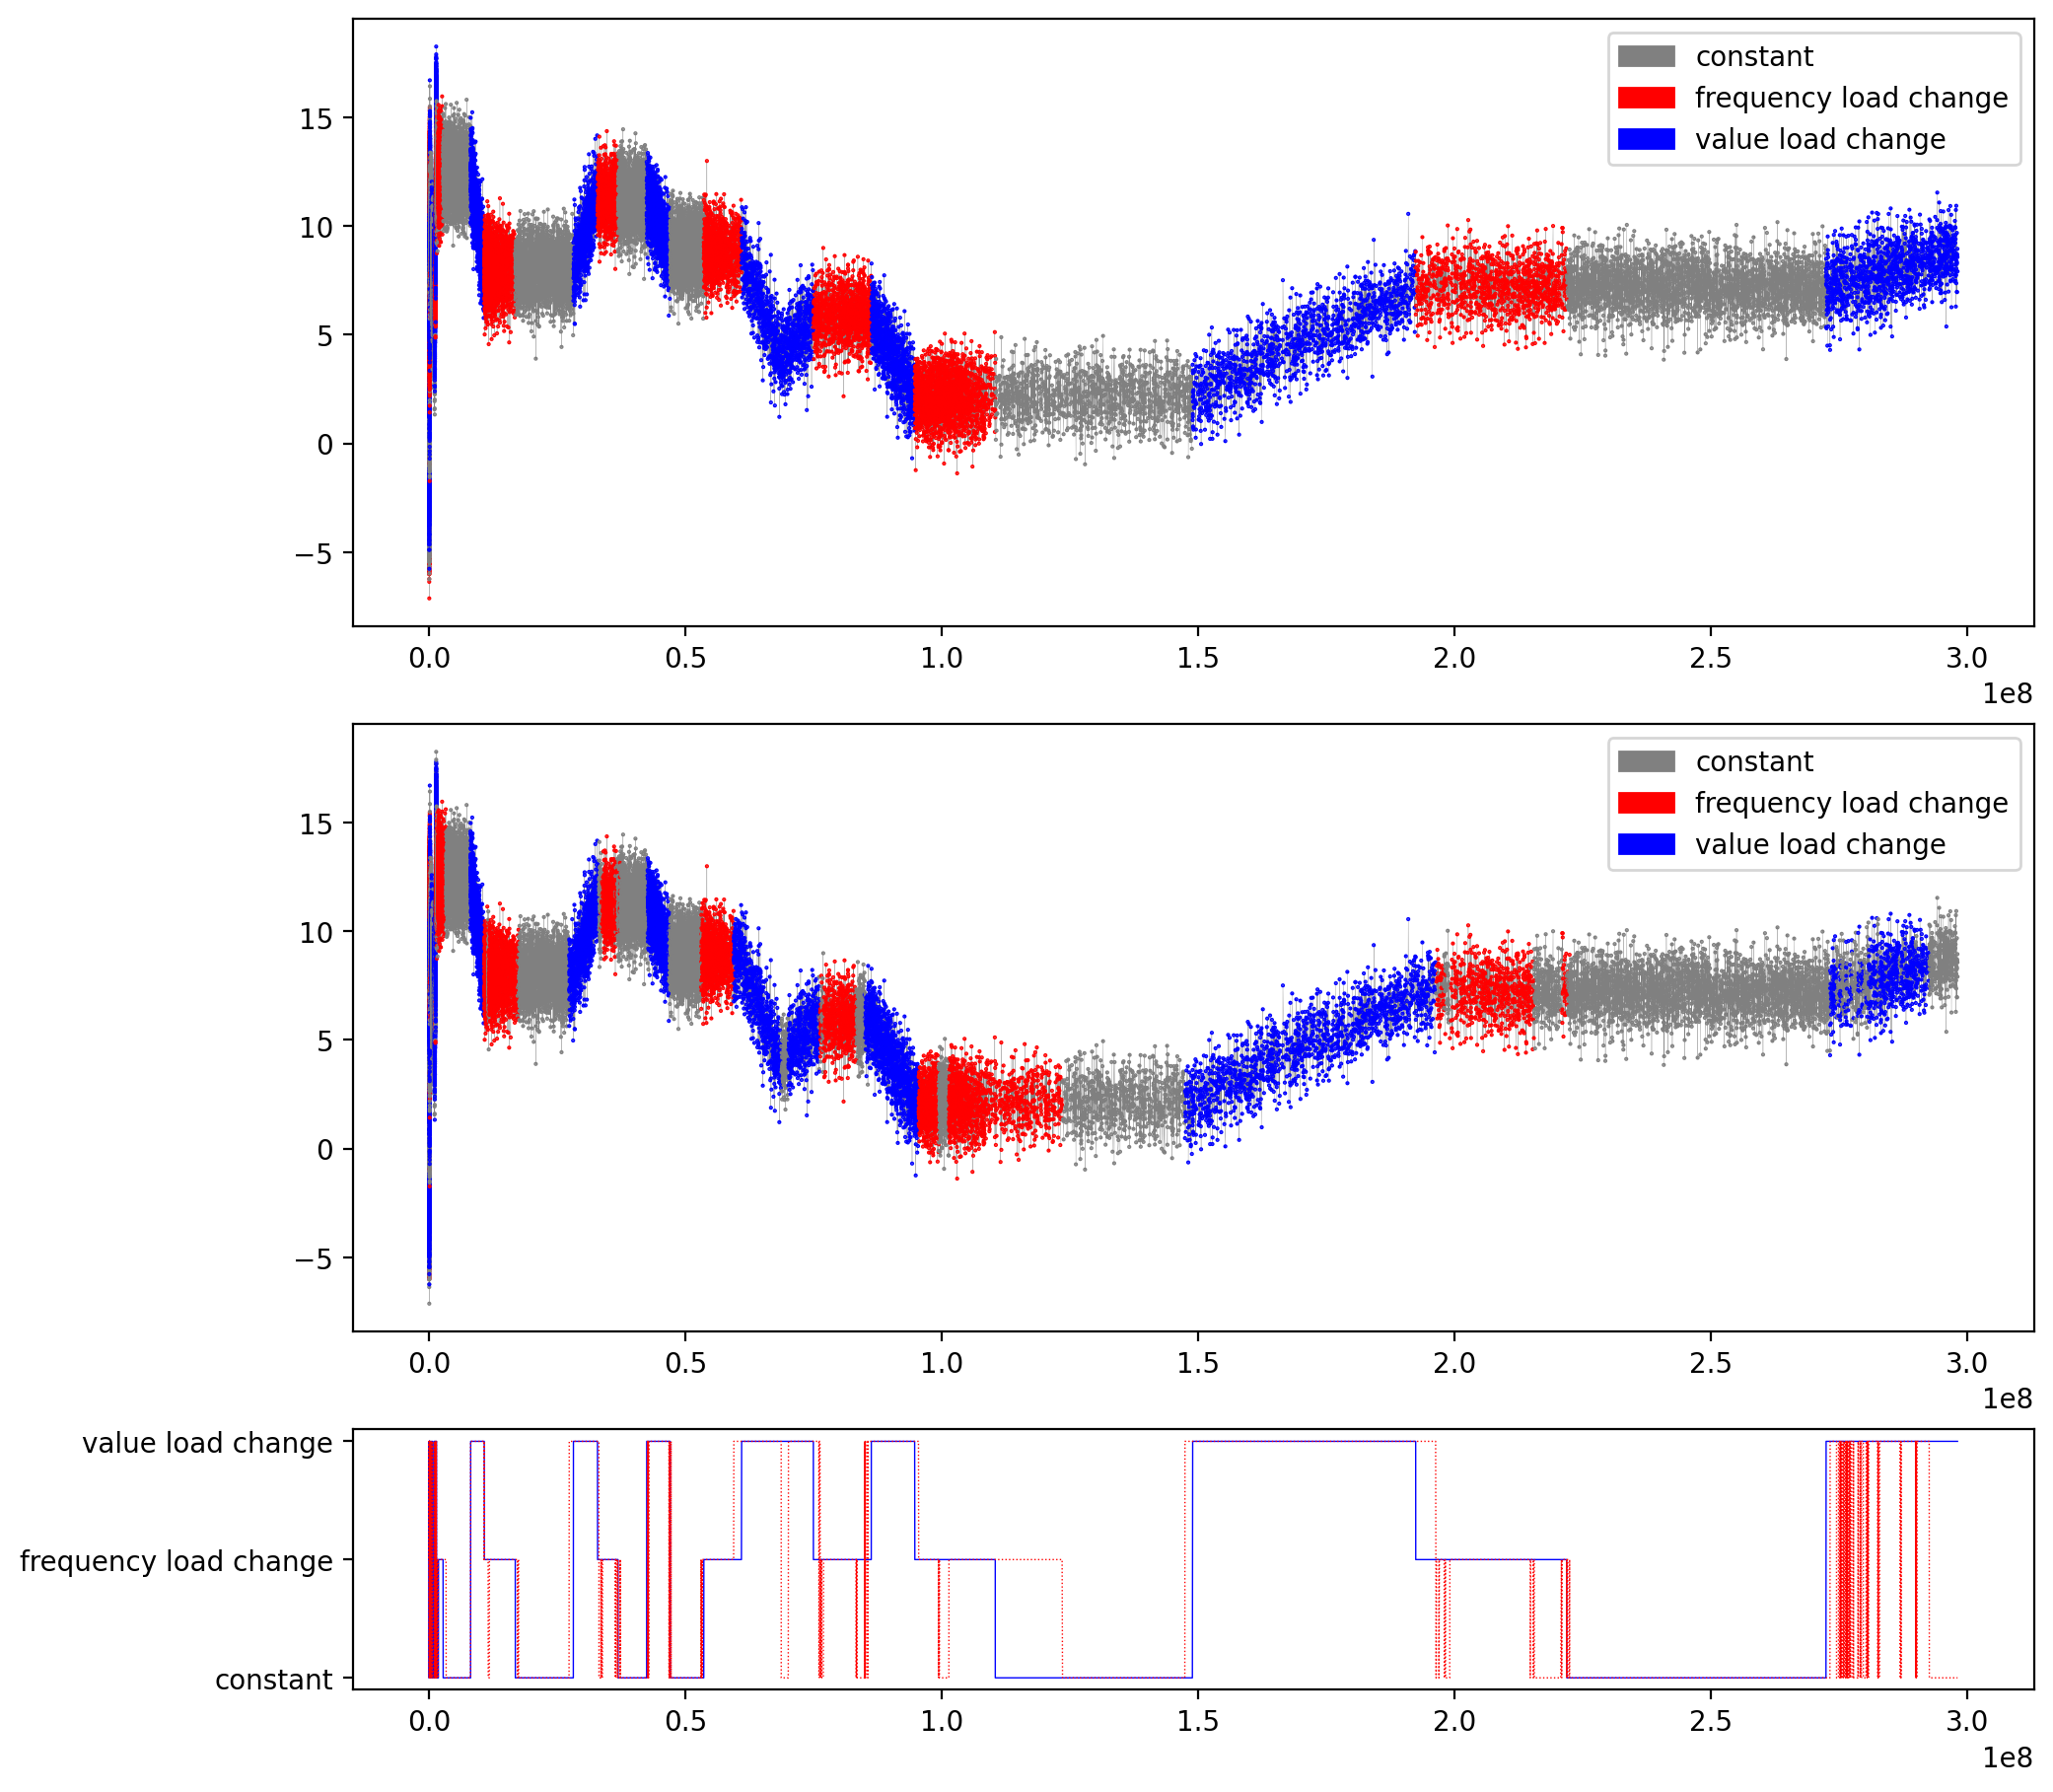

In [196]:
# Visualize optimal

val_ix = np.unravel_index(val_accuracy.argmax(), val_accuracy.shape)
freq_ix = np.unravel_index(freq_accuracy.argmax(), freq_accuracy.shape)

val_ws = win_szs[val_ix[0]].item()
val_thres = thress[val_ix[1]]
freq_ws = win_szs[freq_ix[0]].item()
freq_thres = thress[freq_ix[1]]

pred_signal = np.empty(stream.shape)
cd = DW_ChangeDetector(val_ws, val_thres, freq_ws, freq_thres)
for i, sample in enumerate(stream):
    pred_signal[i, :] = np.abs(cd.update(sample)) # we don't care about the direction of the change rn
pred_signal[:, 0] = np.concatenate((pred_signal[val_ws:, 0], np.zeros(val_ws)))
pred_signal[:, 1] = np.concatenate((pred_signal[freq_ws:, 1], np.zeros(freq_ws)))
pred_signal[:val_ws, 0] = np.zeros(val_ws)
pred_signal[:freq_ws, 1] = np.zeros(freq_ws)
pred_signal = np.max(pred_signal, 1)

# Metric evaluation
accuracy = np.mean(pred_signal == true_signal)
print("Accuracy: ", accuracy)

# f_score

# Plot evaluation
labels = ['constant', 'frequency load change', 'value load change']
colors = ['gray', 'red', 'blue']   
plot_comparison(stream, true_signal, pred_signal, labels=labels, colors=colors)